In [1]:
# Following: https://www.youtube.com/watch?v=WyCDsxZb8Gs

In [5]:
import jax
import jax.numpy as jnp
import equinox as eqx
import optax
import matplotlib.pyplot as plt
from typing import List
import easier as ezr
from tqdm import tqdm


100%|███████████████████████████████████████████████████████████████████████| 30000/30000 [00:23<00:00, 1281.03it/s]


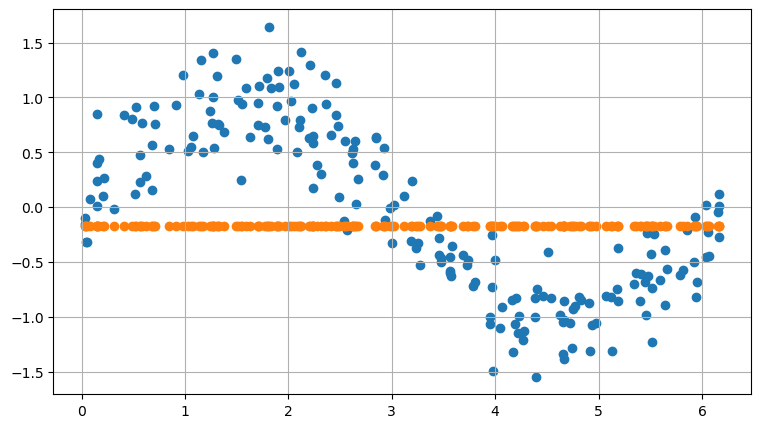

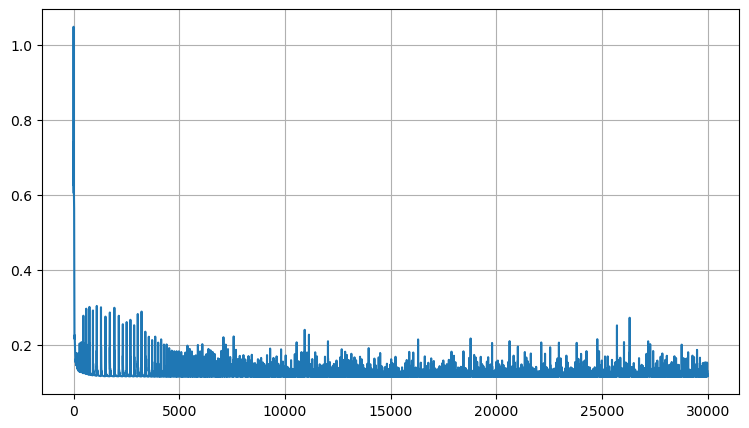

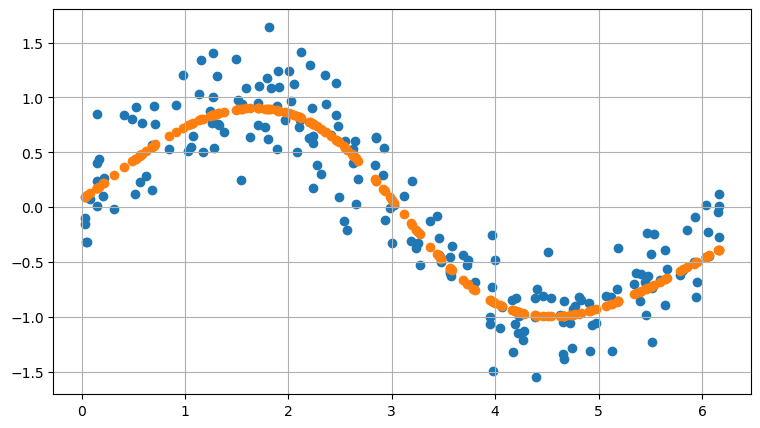

In [67]:

N_SAMPLES = 200
LAYERS = [1, 10, 10, 10, 1]
# LAYERS = [1, 2, 2, 1]

LEARNING_RATE = 0.1
N_EPOCHS = 30_000

key = jax.random.PRNGKey(0)

key = jax.random.PRNGKey(0)
key, xkey, ynoisekey = jax.random.split(key, 3)
x_samples = jax.random.uniform(xkey, shape=(N_SAMPLES, 1), minval=0, maxval=jnp.pi * 2 )
y_samples = jnp.sin(x_samples) + jax.random.normal(ynoisekey, x_samples.shape) * 0.3

class SimpMLP(eqx.Module):
    layers: List[eqx.nn.Linear]
    
    def __init__(self, layer_sizes, key):
        self.layers = []
        
        for (fan_in, fan_out) in zip(layer_sizes[:-1], layer_sizes[1:]):
            key, subkey = jax.random.split(key)
            self.layers.append(
                eqx.nn.Linear(fan_in, fan_out, use_bias=True, key=subkey)
            )
    def __call__(self, x):
        for layer in self.layers[:-1]:
            x = jax.nn.sigmoid(layer(x))
        x = self.layers[-1](x)
        return x

model = SimpMLP(LAYERS, key=key)


def l2_regularization(model):
    v = [jnp.mean(jnp.square(param)) for param in jax.tree_util.tree_leaves(model)]
    return sum(v) / len(v)

def model_to_loss(m, x, y):
    prediction = jax.vmap(m)(x)
    delta = prediction - y
    loss = jnp.mean(delta ** 2)
    l2_reg = l2_regularization(m)
    return loss + .1 * l2_reg

model_to_loss_and_grad = eqx.filter_value_and_grad(model_to_loss)

# opt = optax.adam(LEARNING_RATE)
opt = optax.adam(LEARNING_RATE, )

opt_state = opt.init(eqx.filter(model, eqx.is_array))


@eqx.filter_jit
def make_step(m, opt_s, x, y):
    loss, grad = model_to_loss_and_grad(m, x, y)
    updates, opt_s = opt.update(grad, opt_s, m)
    m = eqx.apply_updates(m, updates)
    return m, opt_s, loss

ax = ezr.figure()
ax.scatter(x_samples, y_samples)
ax.scatter(x_samples, jax.vmap(model)(x_samples))

loss_history = []
for epoch in tqdm(range(N_EPOCHS), total=N_EPOCHS):
    model, opt_state, loss = make_step(model, opt_state, x_samples, y_samples)
    loss_history.append(loss)

ax = ezr.figure()
ax.plot(loss_history)

ax = ezr.figure()
ax.scatter(x_samples, y_samples)
ax.scatter(x_samples, jax.vmap(model)(x_samples))
